In [1]:
%load_ext autoreload
%autoreload 2

# Image Transforms

In [61]:
import albumentations as A

transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=.05, scale_limit=.1, rotate_limit=15, p=.7),
    A.CoarseDropout(num_holes_range=(2, 4), hole_width_range=(0.05, 0.2), hole_height_range=(0.05, 0.2), p=.5),
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 5), p=0.5),
        A.MotionBlur(blur_limit=(3, 5), p=0.5),
    ], p=0.5),
    A.GaussNoise(std_range=(.001, .02), p=0.5),
    A.ColorJitter(brightness=(.4, 1.3), contrast=.3, saturation=(.0, 1.0), hue=.05, p=.8),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.pytorch.ToTensorV2()
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

c:\Users\fazul\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


# Dataset without Synthetic Data

In [65]:
from rare_traffic_signs import RareTrafficSignsDataset
from torch.utils.data import DataLoader, random_split
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

batch_size = 256

train_small_dataset = RareTrafficSignsDataset('./tests/classes.json', './tests/cropped_train')
val_test_small_dataset = RareTrafficSignsDataset('./tests/classes.json', './tests/smalltest', test_classes_csv='./tests/smalltest_annotations.csv')

val_small_size = int(.5 * len(val_test_small_dataset))
test_small_size = len(val_test_small_dataset) - val_small_size

val_small_subset, test_small_subset = random_split(val_test_small_dataset, (val_small_size, test_small_size))

train_small_loader = DataLoader(train_small_dataset, batch_size, shuffle=True, num_workers=16, pin_memory=True, persistent_workers=True)
val_small_loader = DataLoader(val_small_subset, batch_size, shuffle=False)
test_small_loader = DataLoader(test_small_subset, batch_size, shuffle=False)

c:\Users\fazul\OneDrive\Рабочий стол\Мое\Работа\Computer Vision\10 Rare Traffic Signs\rare_traffic_signs.py:92: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=target_size, min_width=target_size, border_mode=cv2.BORDER_CONSTANT, value=0),
c:\Users\fazul\OneDrive\Рабочий стол\Мое\Работа\Computer Vision\10 Rare Traffic Signs\rare_traffic_signs.py:102: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  self.classes = pd.read_json(classes_json, orient='index')
c:\Users\fazul\OneDrive\Рабочий стол\Мое\Работа\Computer Vision\10 Rare Traffic Signs\rare_traffic_signs.py:102: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings 

# EfficientNet

In [72]:
import torch
from torch import nn
import timm
    
model = timm.create_model('efficientnet_b0', pretrained=True)

for param in model.parameters():
    param.requires_grad = False

for block in model.blocks[-2:]:
    for param in block.parameters():
        param.requires_grad = True

for param in model.conv_head.parameters():
    param.requires_grad = True
for param in model.bn2.parameters():
    param.requires_grad = True

num_classes = 205

model.classifier = nn.Sequential(
    nn.Dropout(.2),
    nn.Linear(1280, num_classes)
)
model.to(device)

print(model)

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1 - train accuracy: 0.5625 - train loss: 2.8845 - val accuracy: 0.4541 - val loss: 3.0793
Validation accuracy improved (0.0000 --> 0.4541). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2 - train accuracy: 0.8877 - train loss: 1.2422 - val accuracy: 0.6376 - val loss: 2.3647
Validation accuracy improved (0.4541 --> 0.6376). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3 - train accuracy: 0.9403 - train loss: 1.0681 - val accuracy: 0.6927 - val loss: 2.2627
Validation accuracy improved (0.6376 --> 0.6927). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4 - train accuracy: 0.9649 - train loss: 0.9912 - val accuracy: 0.7156 - val loss: 2.1622
Validation accuracy improved (0.6927 --> 0.7156). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5 - train accuracy: 0.9794 - train loss: 0.9424 - val accuracy: 0.7125 - val loss: 2.1897
Validation accuracy did not improve. Counter: 1/10


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6 - train accuracy: 0.9860 - train loss: 0.9191 - val accuracy: 0.7309 - val loss: 2.0975
Validation accuracy improved (0.7156 --> 0.7309). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7 - train accuracy: 0.9892 - train loss: 0.9082 - val accuracy: 0.7355 - val loss: 2.0807
Validation accuracy improved (0.7309 --> 0.7355). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8 - train accuracy: 0.9918 - train loss: 0.8975 - val accuracy: 0.7370 - val loss: 2.1126
Validation accuracy improved (0.7355 --> 0.7370). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9 - train accuracy: 0.9954 - train loss: 0.8849 - val accuracy: 0.7339 - val loss: 2.0956
Validation accuracy did not improve. Counter: 1/10


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10 - train accuracy: 0.9956 - train loss: 0.8829 - val accuracy: 0.7569 - val loss: 2.0449
Validation accuracy improved (0.7370 --> 0.7569). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11 - train accuracy: 0.9957 - train loss: 0.8810 - val accuracy: 0.7477 - val loss: 2.0083
Validation accuracy did not improve. Counter: 1/10


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12 - train accuracy: 0.9981 - train loss: 0.8713 - val accuracy: 0.7584 - val loss: 2.0135
Validation accuracy improved (0.7569 --> 0.7584). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13 - train accuracy: 0.9990 - train loss: 0.8667 - val accuracy: 0.7584 - val loss: 2.0057
Validation accuracy did not improve. Counter: 1/10


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14 - train accuracy: 0.9991 - train loss: 0.8646 - val accuracy: 0.7523 - val loss: 2.0145
Validation accuracy did not improve. Counter: 2/10


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15 - train accuracy: 0.9995 - train loss: 0.8625 - val accuracy: 0.7492 - val loss: 2.0072
Validation accuracy did not improve. Counter: 3/10


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16 - train accuracy: 0.9996 - train loss: 0.8618 - val accuracy: 0.7599 - val loss: 1.9928
Validation accuracy improved (0.7584 --> 0.7599). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17 - train accuracy: 0.9997 - train loss: 0.8608 - val accuracy: 0.7554 - val loss: 1.9931
Validation accuracy did not improve. Counter: 1/10


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18 - train accuracy: 0.9998 - train loss: 0.8598 - val accuracy: 0.7538 - val loss: 2.0022
Validation accuracy did not improve. Counter: 2/10


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19 - train accuracy: 0.9998 - train loss: 0.8595 - val accuracy: 0.7599 - val loss: 1.9949
Validation accuracy did not improve. Counter: 3/10


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20 - train accuracy: 0.9998 - train loss: 0.8594 - val accuracy: 0.7584 - val loss: 1.9830
Validation accuracy did not improve. Counter: 4/10
Finished Training. Loaded best model.


C:\Users\fazul\AppData\Local\Temp\ipykernel_17856\1163508495.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path_finetune))


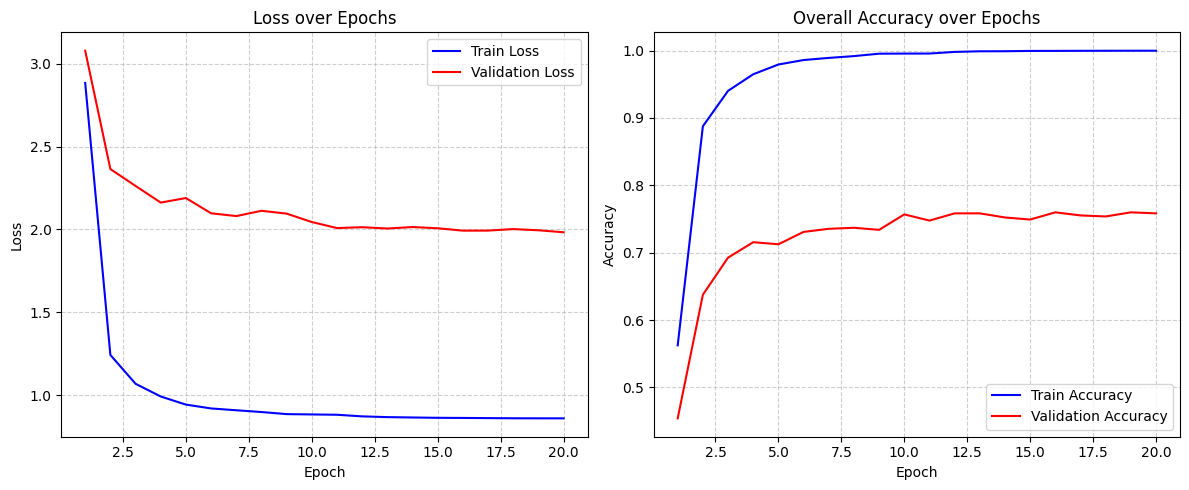

In [ ]:
from torch import nn, optim
import numpy as np
from tqdm.notebook import tqdm 
import os
from rare_traffic_signs import plot_metrics

lr = 5e-5
epochs = 20

params_to_update = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.AdamW(params_to_update, lr=lr)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3, 
    steps_per_epoch=len(train_small_loader),
    epochs=epochs,
    pct_start=0.15,
)

best_val_loss = np.inf
best_val_accuracy = 0
epochs_no_improve = 0
patience = int(epochs/2)
model_path = 'rare_traffic_signs_simple_model_efficientnet.pth'

train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

for epoch in tqdm(range(epochs), position=0, desc='Epoch'):
    model.train()
    train_loss = train_correct = train_seen = 0
    val_loss = val_correct = val_seen = 0

    with tqdm(train_small_loader, position=1, leave=False, desc='Train') as pbar:
        for i, data in enumerate(pbar):
            inputs, targets = data[0].to(device), data[1].to(device).long()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss += loss.item() * inputs.size(0)
            train_correct += torch.sum(outputs.argmax(dim=-1)==targets).item()
            train_seen   += inputs.size(0)
            pbar.set_postfix(
                loss=f'{train_loss/train_seen:.4f}',
                accuracy=f'{train_correct/train_seen:.4f}',
                lr=f'{optimizer.param_groups[0]["lr"]:.6f}'
            )

    model.eval()
    with torch.no_grad():
        for data in val_small_loader:
            inputs, targets = data[0].to(device), data[1].to(device).long()
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item() * inputs.size(0)
            val_correct += torch.sum(outputs.argmax(dim=-1)==targets).item()
            val_seen += inputs.size(0)
    
    train_loss /= train_seen
    train_accuracy = train_correct / train_seen
    val_loss /= val_seen
    val_accuracy = val_correct / val_seen
    
    tqdm.write(f'Epoch {epoch+1} - train accuracy: {train_accuracy:.4f} - train loss: {train_loss:.4f} - val accuracy: {val_accuracy:.4f} - val loss: {val_loss:.4f}')
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_val_accuracy:
        tqdm.write(f'Validation accuracy improved ({best_val_accuracy:.4f} --> {val_accuracy:.4f}). Saving model...')
        torch.save(model.state_dict(), model_path)
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        tqdm.write(f'Validation accuracy did not improve. Counter: {epochs_no_improve}/{patience}')

    if epochs_no_improve >= patience:
        tqdm.write('Early stopping triggered.')
        break


if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print('Finished Training. Loaded best model.')
else:
    print('No improvement during training. Using final model.')

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [ ]:
model_path = 'rare_traffic_signs_simple_model_efficientnet.pth'
model.load_state_dict(torch.load(model_path))
model.to(device=device)
model.eval()

test_loss = test_correct = test_seen = 0

with torch.no_grad():
    for data in test_small_loader:
        inputs, targets = data[0].to(device), data[1].to(device).long()
        outputs = model(inputs)
        test_loss += criterion(outputs, targets).item() * inputs.size(0)
        test_correct += torch.sum(outputs.argmax(dim=-1)==targets).item()
        test_seen += inputs.size(0)

test_loss /= test_seen
test_accuracy = test_correct / test_seen

print(f'Test loss on frequent data: {test_loss:.6f}, test accuracy on frequent data: {test_accuracy:.6f}')

C:\Users\fazul\AppData\Local\Temp\ipykernel_17856\2984328170.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path_finetune))


Test loss on frequent data: 2.042463, test accuracy on frequent data: 0.751145


# Pregenerate Synthetic Data

In [ ]:
from rare_traffic_signs import generate_synthetic_data

# generate_synthetic_data()

Loading file paths...
Generation of 50000 synthetic images...


c:\Users\fazul\OneDrive\Рабочий стол\Мое\Работа\Computer Vision\10 Rare Traffic Signs\rare_traffic_signs.py:155: UserWarning: Argument(s) 'always_apply' are not valid for transform BasicTransform
  super().__init__(always_apply=False, p=p)
c:\Users\fazul\OneDrive\Рабочий стол\Мое\Работа\Computer Vision\10 Rare Traffic Signs\rare_traffic_signs.py:256: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  classes_df = pd.read_json(CLASSES_JSON, orient='index')
c:\Users\fazul\OneDrive\Рабочий стол\Мое\Работа\Computer Vision\10 Rare Traffic Signs\rare_traffic_signs.py:256: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the beha

  0%|          | 0/50000 [00:00<?, ?it/s]

Generation Complete!


# Dataset with Synthetic Data

In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import albumentations as A

transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=.05, scale_limit=.1, rotate_limit=15, p=.7),
    A.CoarseDropout(num_holes_range=(2, 4), hole_width_range=(0.05, 0.2), hole_height_range=(0.05, 0.2), p=.5),
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 5), p=0.5),
        A.MotionBlur(blur_limit=(3, 5), p=0.5),
    ], p=0.5),
    A.GaussNoise(std_range=(.001, .02), p=0.5),
    A.ColorJitter(brightness=(.4, 1.3), contrast=.3, saturation=(.0, 1.0), hue=.05, p=.8),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.pytorch.ToTensorV2()
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

c:\Users\fazul\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [29]:
from rare_traffic_signs import RareTrafficSignsDataset
from torch.utils.data import DataLoader, random_split
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
batch_size = 256

train_full_dataset = RareTrafficSignsDataset('./tests/classes.json', './tests/cropped_train', './tests/generated_images', synthetic_p=0.98, transform=transform)
val_test_full_dataset = RareTrafficSignsDataset('./tests/classes.json', './tests/smalltest', test_classes_csv='./tests/smalltest_annotations.csv')

val_full_size = int(.5 * len(val_test_full_dataset))
test_full_size = len(val_test_full_dataset) - val_full_size

val_full_dataset, test_full_dataset = random_split(val_test_full_dataset, (val_full_size, test_full_size))

train_full_loader = DataLoader(train_full_dataset, batch_size, shuffle=True, num_workers=16, pin_memory=True, persistent_workers=True)
val_full_loader = DataLoader(val_full_dataset, batch_size, shuffle=False)
test_full_loader = DataLoader(test_full_dataset, batch_size, shuffle=False)

c:\Users\fazul\OneDrive\Рабочий стол\Мое\Работа\Computer Vision\10 Rare Traffic Signs\rare_traffic_signs.py:92: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=target_size, min_width=target_size, border_mode=cv2.BORDER_CONSTANT, value=0),
c:\Users\fazul\OneDrive\Рабочий стол\Мое\Работа\Computer Vision\10 Rare Traffic Signs\rare_traffic_signs.py:102: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  self.classes = pd.read_json(classes_json, orient='index')
c:\Users\fazul\OneDrive\Рабочий стол\Мое\Работа\Computer Vision\10 Rare Traffic Signs\rare_traffic_signs.py:102: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings 

c:\Users\fazul\OneDrive\Рабочий стол\Мое\Работа\Computer Vision\10 Rare Traffic Signs\rare_traffic_signs.py:92: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=target_size, min_width=target_size, border_mode=cv2.BORDER_CONSTANT, value=0),
c:\Users\fazul\OneDrive\Рабочий стол\Мое\Работа\Computer Vision\10 Rare Traffic Signs\rare_traffic_signs.py:102: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  self.classes = pd.read_json(classes_json, orient='index')
c:\Users\fazul\OneDrive\Рабочий стол\Мое\Работа\Computer Vision\10 Rare Traffic Signs\rare_traffic_signs.py:102: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings 

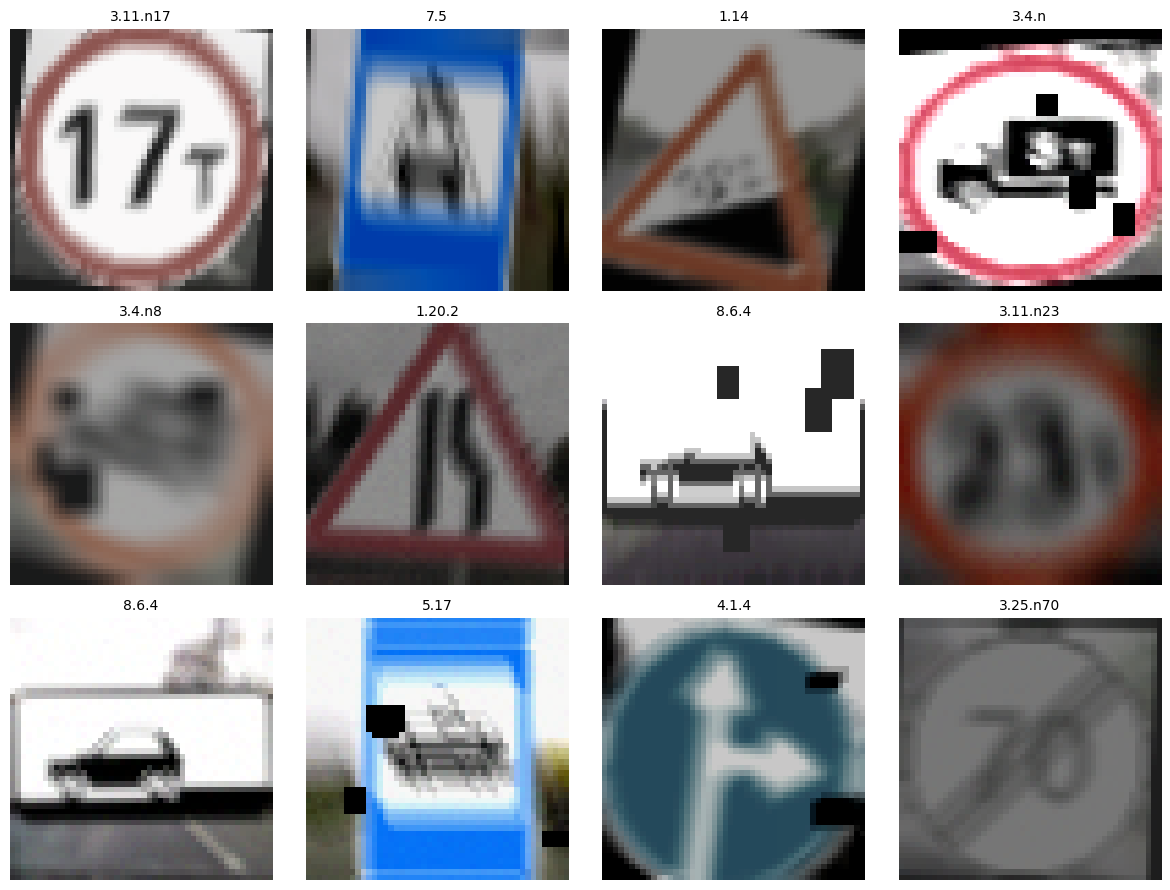

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

synthetic_dataset = RareTrafficSignsDataset('./tests/classes.json', './tests/generated_images', transform=transform)

batch_size = 12
loader = DataLoader(synthetic_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

classes_df = pd.read_json('./tests/classes.json', orient='index', convert_dates=False)
id_to_name = pd.Series(classes_df.index, index=classes_df['id']).to_dict()

mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

def denorm(batch):
    batch_cpu = batch.cpu()
    mean_cpu = mean.cpu()
    std_cpu = std.cpu()
    return batch_cpu * std_cpu + mean_cpu

imgs, labels = next(iter(loader))
imgs_denorm = denorm(imgs)

cols = 4
rows = (batch_size + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
axes = axes.flatten()

for i, (img, label_id) in enumerate(zip(imgs_denorm, labels)):
    ax = axes[i]
    
    img_np = img.permute(1, 2, 0).numpy()
    ax.imshow(img_np)
    
    class_name = id_to_name.get(label_id.item(), "Unknown")
    ax.set_title(class_name, fontsize=10)
    ax.axis('off')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# EfficientNet

In [45]:
import torch
from torch import nn
import timm
    
model = timm.create_model('efficientnet_b0', pretrained=True)

for param in model.parameters():
    param.requires_grad = False

for block in model.blocks[-3:]:
    for param in block.parameters():
        param.requires_grad = True

for param in model.conv_head.parameters():
    param.requires_grad = True
for param in model.bn2.parameters():
    param.requires_grad = True

num_classes = 205

model.classifier = nn.Sequential(
    nn.Dropout(.2),
    nn.Linear(1280, num_classes)
)
model.to(device)

print(model)

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

C:\Users\fazul\AppData\Local\Temp\ipykernel_17856\3871549013.py:38: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  classes = pd.read_json('./tests/classes.json', orient='index', convert_dates=False)
C:\Users\fazul\AppData\Local\Temp\ipykernel_17856\3871549013.py:38: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  classes = pd.read_json('./tests/classes.json', orient='index', convert_dates=False)
C:\Users\fazul\AppData\Local\Temp\ipykernel_17856\3871549013.py:38: FutureWarning: The beh

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1 - train accuracy: 0.0581 - train loss: 4.9614 - train recall rare: 0.0724 - val accuracy: 0.1239 - val loss: 4.6044 - val recall rare: 0.0506
Validation recall on rare classes improved (0.0000 --> 0.0506). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2 - train accuracy: 0.3332 - train loss: 3.2352 - train recall rare: 0.4063 - val accuracy: 0.4052 - val loss: 2.8537 - val recall rare: 0.2405
Validation recall on rare classes improved (0.0506 --> 0.2405). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3 - train accuracy: 0.6233 - train loss: 1.9535 - train recall rare: 0.7238 - val accuracy: 0.5627 - val loss: 2.3074 - val recall rare: 0.3165
Validation recall on rare classes improved (0.2405 --> 0.3165). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4 - train accuracy: 0.7518 - train loss: 1.5540 - train recall rare: 0.8516 - val accuracy: 0.6437 - val loss: 2.0939 - val recall rare: 0.3671
Validation recall on rare classes improved (0.3165 --> 0.3671). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5 - train accuracy: 0.8090 - train loss: 1.3957 - train recall rare: 0.9017 - val accuracy: 0.6682 - val loss: 1.9813 - val recall rare: 0.4810
Validation recall on rare classes improved (0.3671 --> 0.4810). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6 - train accuracy: 0.8385 - train loss: 1.3147 - train recall rare: 0.9332 - val accuracy: 0.7125 - val loss: 1.9308 - val recall rare: 0.5696
Validation recall on rare classes improved (0.4810 --> 0.5696). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7 - train accuracy: 0.8545 - train loss: 1.2631 - train recall rare: 0.9441 - val accuracy: 0.7171 - val loss: 1.8128 - val recall rare: 0.4937
Validation recall on rare classes did not improve. Counter: 1/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8 - train accuracy: 0.8684 - train loss: 1.2243 - train recall rare: 0.9521 - val accuracy: 0.7385 - val loss: 1.7866 - val recall rare: 0.5823
Validation recall on rare classes improved (0.5696 --> 0.5823). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9 - train accuracy: 0.8766 - train loss: 1.1994 - train recall rare: 0.9555 - val accuracy: 0.7416 - val loss: 1.7115 - val recall rare: 0.5443
Validation recall on rare classes did not improve. Counter: 1/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10 - train accuracy: 0.8818 - train loss: 1.1860 - train recall rare: 0.9610 - val accuracy: 0.7431 - val loss: 1.6957 - val recall rare: 0.5696
Validation recall on rare classes did not improve. Counter: 2/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11 - train accuracy: 0.8912 - train loss: 1.1579 - train recall rare: 0.9710 - val accuracy: 0.7523 - val loss: 1.7250 - val recall rare: 0.5316
Validation recall on rare classes did not improve. Counter: 3/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12 - train accuracy: 0.8952 - train loss: 1.1437 - train recall rare: 0.9707 - val accuracy: 0.7446 - val loss: 1.6953 - val recall rare: 0.5949
Validation recall on rare classes improved (0.5823 --> 0.5949). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13 - train accuracy: 0.8975 - train loss: 1.1352 - train recall rare: 0.9741 - val accuracy: 0.7737 - val loss: 1.6030 - val recall rare: 0.5063
Validation recall on rare classes did not improve. Counter: 1/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14 - train accuracy: 0.9036 - train loss: 1.1191 - train recall rare: 0.9801 - val accuracy: 0.7615 - val loss: 1.6752 - val recall rare: 0.5570
Validation recall on rare classes did not improve. Counter: 2/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15 - train accuracy: 0.9070 - train loss: 1.1073 - train recall rare: 0.9778 - val accuracy: 0.7798 - val loss: 1.6051 - val recall rare: 0.6203
Validation recall on rare classes improved (0.5949 --> 0.6203). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16 - train accuracy: 0.9082 - train loss: 1.1059 - train recall rare: 0.9808 - val accuracy: 0.7599 - val loss: 1.6719 - val recall rare: 0.4937
Validation recall on rare classes did not improve. Counter: 1/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17 - train accuracy: 0.9110 - train loss: 1.0966 - train recall rare: 0.9800 - val accuracy: 0.7875 - val loss: 1.6267 - val recall rare: 0.5696
Validation recall on rare classes did not improve. Counter: 2/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18 - train accuracy: 0.9140 - train loss: 1.0896 - train recall rare: 0.9843 - val accuracy: 0.7508 - val loss: 1.6706 - val recall rare: 0.5190
Validation recall on rare classes did not improve. Counter: 3/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19 - train accuracy: 0.9153 - train loss: 1.0849 - train recall rare: 0.9869 - val accuracy: 0.7783 - val loss: 1.5910 - val recall rare: 0.5570
Validation recall on rare classes did not improve. Counter: 4/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20 - train accuracy: 0.9173 - train loss: 1.0764 - train recall rare: 0.9900 - val accuracy: 0.7844 - val loss: 1.6115 - val recall rare: 0.5570
Validation recall on rare classes did not improve. Counter: 5/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 21 - train accuracy: 0.9219 - train loss: 1.0683 - train recall rare: 0.9913 - val accuracy: 0.8104 - val loss: 1.5721 - val recall rare: 0.6203
Validation recall on rare classes improved (0.6203 --> 0.6203). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 22 - train accuracy: 0.9231 - train loss: 1.0599 - train recall rare: 0.9907 - val accuracy: 0.7936 - val loss: 1.5529 - val recall rare: 0.5190
Validation recall on rare classes did not improve. Counter: 1/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 23 - train accuracy: 0.9253 - train loss: 1.0541 - train recall rare: 0.9930 - val accuracy: 0.8012 - val loss: 1.5673 - val recall rare: 0.5316
Validation recall on rare classes did not improve. Counter: 2/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 24 - train accuracy: 0.9289 - train loss: 1.0455 - train recall rare: 0.9971 - val accuracy: 0.8135 - val loss: 1.5457 - val recall rare: 0.5696
Validation recall on rare classes did not improve. Counter: 3/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25 - train accuracy: 0.9308 - train loss: 1.0437 - train recall rare: 0.9969 - val accuracy: 0.7844 - val loss: 1.5771 - val recall rare: 0.4684
Validation recall on rare classes did not improve. Counter: 4/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 26 - train accuracy: 0.9330 - train loss: 1.0360 - train recall rare: 0.9993 - val accuracy: 0.7951 - val loss: 1.5752 - val recall rare: 0.5190
Validation recall on rare classes did not improve. Counter: 5/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 27 - train accuracy: 0.9317 - train loss: 1.0370 - train recall rare: 0.9976 - val accuracy: 0.8150 - val loss: 1.5375 - val recall rare: 0.5190
Validation recall on rare classes did not improve. Counter: 6/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 28 - train accuracy: 0.9325 - train loss: 1.0330 - train recall rare: 0.9962 - val accuracy: 0.7997 - val loss: 1.5628 - val recall rare: 0.5190
Validation recall on rare classes did not improve. Counter: 7/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 29 - train accuracy: 0.9352 - train loss: 1.0239 - train recall rare: 1.0007 - val accuracy: 0.8165 - val loss: 1.5093 - val recall rare: 0.5570
Validation recall on rare classes did not improve. Counter: 8/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 30 - train accuracy: 0.9369 - train loss: 1.0213 - train recall rare: 1.0040 - val accuracy: 0.8089 - val loss: 1.5395 - val recall rare: 0.5696
Validation recall on rare classes did not improve. Counter: 9/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 31 - train accuracy: 0.9397 - train loss: 1.0126 - train recall rare: 1.0049 - val accuracy: 0.8135 - val loss: 1.5089 - val recall rare: 0.5190
Validation recall on rare classes did not improve. Counter: 10/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 32 - train accuracy: 0.9411 - train loss: 1.0093 - train recall rare: 1.0044 - val accuracy: 0.8333 - val loss: 1.4770 - val recall rare: 0.5696
Validation recall on rare classes did not improve. Counter: 11/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 33 - train accuracy: 0.9420 - train loss: 1.0051 - train recall rare: 1.0047 - val accuracy: 0.8440 - val loss: 1.4598 - val recall rare: 0.6076
Validation recall on rare classes did not improve. Counter: 12/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 34 - train accuracy: 0.9433 - train loss: 1.0024 - train recall rare: 1.0039 - val accuracy: 0.8440 - val loss: 1.4223 - val recall rare: 0.5949
Validation recall on rare classes did not improve. Counter: 13/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 35 - train accuracy: 0.9450 - train loss: 0.9984 - train recall rare: 1.0056 - val accuracy: 0.8394 - val loss: 1.4134 - val recall rare: 0.5696
Validation recall on rare classes did not improve. Counter: 14/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 36 - train accuracy: 0.9479 - train loss: 0.9896 - train recall rare: 1.0084 - val accuracy: 0.8333 - val loss: 1.4314 - val recall rare: 0.5696
Validation recall on rare classes did not improve. Counter: 15/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 37 - train accuracy: 0.9484 - train loss: 0.9874 - train recall rare: 1.0095 - val accuracy: 0.8410 - val loss: 1.4549 - val recall rare: 0.5316
Validation recall on rare classes did not improve. Counter: 16/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 38 - train accuracy: 0.9496 - train loss: 0.9852 - train recall rare: 1.0102 - val accuracy: 0.8456 - val loss: 1.4060 - val recall rare: 0.5570
Validation recall on rare classes did not improve. Counter: 17/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 39 - train accuracy: 0.9507 - train loss: 0.9806 - train recall rare: 1.0091 - val accuracy: 0.8502 - val loss: 1.4060 - val recall rare: 0.5823
Validation recall on rare classes did not improve. Counter: 18/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 40 - train accuracy: 0.9504 - train loss: 0.9798 - train recall rare: 1.0126 - val accuracy: 0.8471 - val loss: 1.4049 - val recall rare: 0.5823
Validation recall on rare classes did not improve. Counter: 19/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 41 - train accuracy: 0.9537 - train loss: 0.9748 - train recall rare: 1.0140 - val accuracy: 0.8563 - val loss: 1.3948 - val recall rare: 0.6076
Validation recall on rare classes did not improve. Counter: 20/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 42 - train accuracy: 0.9547 - train loss: 0.9715 - train recall rare: 1.0151 - val accuracy: 0.8532 - val loss: 1.3819 - val recall rare: 0.5696
Validation recall on rare classes did not improve. Counter: 21/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 43 - train accuracy: 0.9540 - train loss: 0.9725 - train recall rare: 1.0118 - val accuracy: 0.8547 - val loss: 1.3922 - val recall rare: 0.5316
Validation recall on rare classes did not improve. Counter: 22/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 44 - train accuracy: 0.9557 - train loss: 0.9673 - train recall rare: 1.0139 - val accuracy: 0.8563 - val loss: 1.3910 - val recall rare: 0.5696
Validation recall on rare classes did not improve. Counter: 23/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 45 - train accuracy: 0.9564 - train loss: 0.9680 - train recall rare: 1.0148 - val accuracy: 0.8624 - val loss: 1.3892 - val recall rare: 0.6076
Validation recall on rare classes did not improve. Counter: 24/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 46 - train accuracy: 0.9575 - train loss: 0.9635 - train recall rare: 1.0148 - val accuracy: 0.8563 - val loss: 1.3862 - val recall rare: 0.5570
Validation recall on rare classes did not improve. Counter: 25/25
Early stopping triggered.
Finished Training. Loaded best model.


C:\Users\fazul\AppData\Local\Temp\ipykernel_17856\3871549013.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path_finetune))


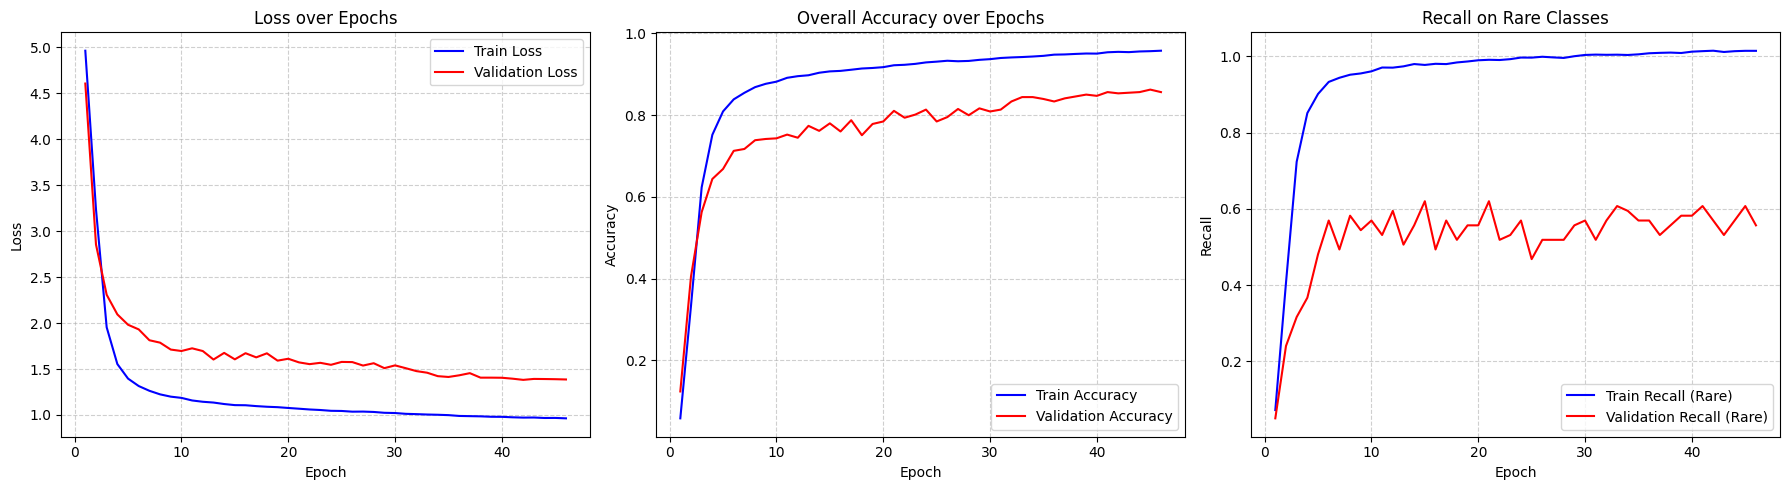

In [ ]:
from torch import nn, optim
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm 
import os
from rare_traffic_signs import plot_metrics

lr = 5e-5
epochs = 50

params_to_update = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.AdamW(params_to_update, lr=lr)
criterion = nn.CrossEntropyLoss(label_smoothing=0.10)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=8e-4, 
    steps_per_epoch=len(train_full_loader),
    epochs=epochs,
    pct_start=0.2,
)

best_val_loss = np.inf
best_val_accuracy = 0.0
best_val_recall_rare = 0.0
epochs_no_improve = 0
patience = int(epochs/2)

model_path = 'rare_traffic_signs_complex_model_efficientnet.pth'

train_accuracies = []
train_losses = []
train_recalls_rare = []
val_accuracies = []
val_losses = []
val_recalls_rare = []

classes = pd.read_json('./tests/classes.json', orient='index', convert_dates=False)
name_to_id = classes['id'].to_dict()
rare_class_names = set(classes.index[classes['type'] == 'rare'])
rare_class_ids = torch.tensor([name_to_id[name] for name in rare_class_names], device=device, dtype=torch.long)

for epoch in tqdm(range(epochs), position=0, desc='Epoch'):
    
    train_loss = train_correct = train_correct_rare = train_seen = train_seen_rare = 0
    val_loss = val_correct = val_correct_rare = val_seen = val_seen_rare = 0

    model.train()

    with tqdm(train_full_loader, position=1, leave=False, desc='Train') as pbar:
        for i, data in enumerate(pbar):
            inputs, targets = data[0].to(device), data[1].to(device).long()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

            is_target_rare = torch.isin(targets, rare_class_ids)

            train_loss += loss.item() * inputs.size(0)
            train_correct += torch.sum(outputs.argmax(dim=-1)==targets).item()
            train_correct_rare += torch.sum((outputs.argmax(dim=-1)==targets) * ~is_target_rare).item()
            train_seen += inputs.size(0)
            train_seen_rare += torch.sum(is_target_rare)

            pbar.set_postfix(
                loss=f'{train_loss/train_seen:.4f}',
                accuracy=f'{train_correct/train_seen:.4f}',
                recall_rare=f'{train_correct_rare/(train_seen_rare+1e-9):.4f}',
                lr=f'{optimizer.param_groups[0]["lr"]:.6f}'
            )

    model.eval()
    with torch.no_grad():
        for data in val_full_loader:
            inputs, targets = data[0].to(device), data[1].to(device).long()
            outputs = model(inputs)

            is_target_rare = torch.isin(targets, rare_class_ids)

            val_loss += criterion(outputs, targets).item() * inputs.size(0)
            val_correct += torch.sum(outputs.argmax(dim=-1)==targets).item()
            val_correct_rare += torch.sum((outputs.argmax(dim=-1)==targets) * is_target_rare).item()
            val_seen += inputs.size(0)
            val_seen_rare += torch.sum(is_target_rare)
    
    train_loss /= train_seen
    train_accuracy = train_correct / train_seen
    train_recall_rare = train_correct_rare / (train_seen_rare)
    val_loss /= val_seen
    val_accuracy = val_correct / val_seen
    val_recall_rare = val_correct_rare / (val_seen_rare+1e-9)
    
    tqdm.write(f'Epoch {epoch+1} - train accuracy: {train_accuracy:.4f} - train loss: {train_loss:.4f} - train recall rare: {train_recall_rare:.4f} - val accuracy: {val_accuracy:.4f} - val loss: {val_loss:.4f} - val recall rare: {val_recall_rare:.4f}')
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_recalls_rare.append(train_recall_rare)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_recalls_rare.append(val_recall_rare)

    if val_recall_rare > best_val_recall_rare or ((val_recall_rare == best_val_recall_rare) and (val_accuracy > best_val_accuracy)):
        tqdm.write(f'Validation recall on rare classes improved ({best_val_recall_rare:.4f} --> {val_recall_rare:.4f}). Saving model...')
        torch.save(model.state_dict(), model_path)
        best_val_recall_rare = val_recall_rare
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        tqdm.write(f'Validation recall on rare classes did not improve. Counter: {epochs_no_improve}/{patience}')

    if epochs_no_improve >= patience:
        tqdm.write('Early stopping triggered.')
        break


if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print('Finished Training. Loaded best model.')
else:
    print('No improvement during training. Using final model.')

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, train_recall_rare=train_recalls_rare, val_recall_rare=val_recalls_rare)

In [ ]:
model_path = 'rare_traffic_signs_complex_model_efficientnet.pth'
model.load_state_dict(torch.load(model_path))
model.to(device=device)

model.eval()

classes = pd.read_json('./tests/classes.json', orient='index', convert_dates=False)
name_to_id = classes['id'].to_dict()
rare_class_names = set(classes.index[classes['type'] == 'rare'])
rare_class_ids = torch.tensor([name_to_id[name] for name in rare_class_names], device=device, dtype=torch.long)

test_loss = test_correct = test_correct_rare = test_seen = test_seen_rare = 0

with torch.no_grad():
    for data in test_full_loader:
        inputs, targets = data[0].to(device), data[1].to(device).long()
        outputs = model(inputs)

        is_target_rare = torch.isin(targets, rare_class_ids)
        
        test_loss += criterion(outputs, targets).item() * inputs.size(0)
        test_correct += torch.sum(outputs.argmax(dim=-1)==targets).item()
        test_correct_rare += torch.sum((outputs.argmax(dim=-1)==targets) * is_target_rare).item()
        test_seen += inputs.size(0)
        test_seen_rare += torch.sum(is_target_rare)

test_loss /= test_seen
test_accuracy = test_correct / test_seen
test_recall_rare = test_correct_rare / (test_seen_rare+1e-9)

print(f'Test loss: {test_loss:.6f}, test accuracy: {test_accuracy:.6f}, test recall on rare data: {test_recall_rare:.6f}')

C:\Users\fazul\AppData\Local\Temp\ipykernel_17856\1977542192.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path_finetune))
C:\Us

Test loss: 1.519284, test accuracy: 0.803053, test recall on rare data: 0.534884


# EfficientNet with Contrastive Loss on the Penultimate Layer

In [47]:
import torch
from torch import nn
import timm

class EfficientNetWithFeatureLoss(nn.Module):
    def __init__(self, num_classes=205, freeze=True):
        super().__init__()

        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0)
        feat_dim = self.backbone.num_features

        if freeze:
            for p in self.backbone.parameters():
                p.requires_grad = False

            for blk in self.backbone.blocks[-3:]:
                for p in blk.parameters():
                    p.requires_grad = True
        
            for p in self.backbone.conv_head.parameters(): p.requires_grad = True
            for p in self.backbone.bn2.parameters(): p.requires_grad = True

        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(feat_dim, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        logits = self.classifier(features)
        return logits, features
    
model = EfficientNetWithFeatureLoss().to(device=device)

C:\Users\fazul\AppData\Local\Temp\ipykernel_17856\2545033967.py:39: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  classes = pd.read_json('./tests/classes.json', orient='index', convert_dates=False)
C:\Users\fazul\AppData\Local\Temp\ipykernel_17856\2545033967.py:39: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  classes = pd.read_json('./tests/classes.json', orient='index', convert_dates=False)
C:\Users\fazul\AppData\Local\Temp\ipykernel_17856\2545033967.py:39: FutureWarning: The beh

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1 - train accuracy: 0.0611 - train loss: 5.2725 - train recall rare: 0.0466 - val accuracy: 0.1346 - val loss: 4.5099 - val recall rare: 0.0633
Validation recall on rare classes improved (0.0000 --> 0.0633). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2 - train accuracy: 0.3428 - train loss: 3.4137 - train recall rare: 0.2812 - val accuracy: 0.4098 - val loss: 2.8516 - val recall rare: 0.1392
Validation recall on rare classes improved (0.0633 --> 0.1392). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3 - train accuracy: 0.6229 - train loss: 2.1386 - train recall rare: 0.5481 - val accuracy: 0.5780 - val loss: 2.2744 - val recall rare: 0.3165
Validation recall on rare classes improved (0.1392 --> 0.3165). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4 - train accuracy: 0.7492 - train loss: 1.7342 - train recall rare: 0.6772 - val accuracy: 0.6315 - val loss: 2.0674 - val recall rare: 0.3924
Validation recall on rare classes improved (0.3165 --> 0.3924). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5 - train accuracy: 0.8097 - train loss: 1.5508 - train recall rare: 0.7449 - val accuracy: 0.6789 - val loss: 1.9678 - val recall rare: 0.4684
Validation recall on rare classes improved (0.3924 --> 0.4684). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6 - train accuracy: 0.8389 - train loss: 1.4592 - train recall rare: 0.7833 - val accuracy: 0.7202 - val loss: 1.9185 - val recall rare: 0.5063
Validation recall on rare classes improved (0.4684 --> 0.5063). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7 - train accuracy: 0.8513 - train loss: 1.4114 - train recall rare: 0.8002 - val accuracy: 0.7248 - val loss: 1.8132 - val recall rare: 0.4810
Validation recall on rare classes did not improve. Counter: 1/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8 - train accuracy: 0.8641 - train loss: 1.3710 - train recall rare: 0.8155 - val accuracy: 0.7278 - val loss: 1.8241 - val recall rare: 0.5316
Validation recall on rare classes improved (0.5063 --> 0.5316). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9 - train accuracy: 0.8745 - train loss: 1.3371 - train recall rare: 0.8304 - val accuracy: 0.7492 - val loss: 1.7320 - val recall rare: 0.5696
Validation recall on rare classes improved (0.5316 --> 0.5696). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10 - train accuracy: 0.8793 - train loss: 1.3149 - train recall rare: 0.8370 - val accuracy: 0.7294 - val loss: 1.7580 - val recall rare: 0.5063
Validation recall on rare classes did not improve. Counter: 1/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11 - train accuracy: 0.8867 - train loss: 1.2885 - train recall rare: 0.8441 - val accuracy: 0.7508 - val loss: 1.7393 - val recall rare: 0.4937
Validation recall on rare classes did not improve. Counter: 2/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12 - train accuracy: 0.8880 - train loss: 1.2838 - train recall rare: 0.8478 - val accuracy: 0.7508 - val loss: 1.7251 - val recall rare: 0.5443
Validation recall on rare classes did not improve. Counter: 3/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13 - train accuracy: 0.8976 - train loss: 1.2559 - train recall rare: 0.8612 - val accuracy: 0.7278 - val loss: 1.8284 - val recall rare: 0.5063
Validation recall on rare classes did not improve. Counter: 4/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14 - train accuracy: 0.8992 - train loss: 1.2477 - train recall rare: 0.8620 - val accuracy: 0.7615 - val loss: 1.7067 - val recall rare: 0.4937
Validation recall on rare classes did not improve. Counter: 5/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15 - train accuracy: 0.9023 - train loss: 1.2361 - train recall rare: 0.8685 - val accuracy: 0.7768 - val loss: 1.6610 - val recall rare: 0.5570
Validation recall on rare classes did not improve. Counter: 6/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16 - train accuracy: 0.9050 - train loss: 1.2311 - train recall rare: 0.8717 - val accuracy: 0.7875 - val loss: 1.5894 - val recall rare: 0.5696
Validation recall on rare classes improved (0.5696 --> 0.5696). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17 - train accuracy: 0.9090 - train loss: 1.2149 - train recall rare: 0.8756 - val accuracy: 0.7936 - val loss: 1.5631 - val recall rare: 0.5570
Validation recall on rare classes did not improve. Counter: 1/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18 - train accuracy: 0.9116 - train loss: 1.2040 - train recall rare: 0.8784 - val accuracy: 0.7920 - val loss: 1.5783 - val recall rare: 0.5823
Validation recall on rare classes improved (0.5696 --> 0.5823). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19 - train accuracy: 0.9131 - train loss: 1.1999 - train recall rare: 0.8807 - val accuracy: 0.7630 - val loss: 1.6839 - val recall rare: 0.5443
Validation recall on rare classes did not improve. Counter: 1/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20 - train accuracy: 0.9171 - train loss: 1.1890 - train recall rare: 0.8866 - val accuracy: 0.7676 - val loss: 1.6905 - val recall rare: 0.5190
Validation recall on rare classes did not improve. Counter: 2/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 21 - train accuracy: 0.9161 - train loss: 1.1881 - train recall rare: 0.8843 - val accuracy: 0.7951 - val loss: 1.5789 - val recall rare: 0.5823
Validation recall on rare classes improved (0.5823 --> 0.5823). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 22 - train accuracy: 0.9222 - train loss: 1.1721 - train recall rare: 0.8927 - val accuracy: 0.7966 - val loss: 1.5714 - val recall rare: 0.5316
Validation recall on rare classes did not improve. Counter: 1/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 23 - train accuracy: 0.9222 - train loss: 1.1707 - train recall rare: 0.8945 - val accuracy: 0.7920 - val loss: 1.6349 - val recall rare: 0.5443
Validation recall on rare classes did not improve. Counter: 2/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 24 - train accuracy: 0.9225 - train loss: 1.1683 - train recall rare: 0.8947 - val accuracy: 0.8073 - val loss: 1.5451 - val recall rare: 0.5570
Validation recall on rare classes did not improve. Counter: 3/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25 - train accuracy: 0.9255 - train loss: 1.1563 - train recall rare: 0.8982 - val accuracy: 0.8135 - val loss: 1.5131 - val recall rare: 0.5443
Validation recall on rare classes did not improve. Counter: 4/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 26 - train accuracy: 0.9295 - train loss: 1.1473 - train recall rare: 0.9024 - val accuracy: 0.8073 - val loss: 1.5201 - val recall rare: 0.5570
Validation recall on rare classes did not improve. Counter: 5/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 27 - train accuracy: 0.9291 - train loss: 1.1466 - train recall rare: 0.9023 - val accuracy: 0.8303 - val loss: 1.5040 - val recall rare: 0.5443
Validation recall on rare classes did not improve. Counter: 6/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 28 - train accuracy: 0.9328 - train loss: 1.1360 - train recall rare: 0.9073 - val accuracy: 0.8226 - val loss: 1.5067 - val recall rare: 0.5696
Validation recall on rare classes did not improve. Counter: 7/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 29 - train accuracy: 0.9338 - train loss: 1.1316 - train recall rare: 0.9085 - val accuracy: 0.8150 - val loss: 1.5301 - val recall rare: 0.5696
Validation recall on rare classes did not improve. Counter: 8/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 30 - train accuracy: 0.9369 - train loss: 1.1263 - train recall rare: 0.9140 - val accuracy: 0.8089 - val loss: 1.5068 - val recall rare: 0.5823
Validation recall on rare classes improved (0.5823 --> 0.5823). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 31 - train accuracy: 0.9374 - train loss: 1.1204 - train recall rare: 0.9132 - val accuracy: 0.8257 - val loss: 1.4758 - val recall rare: 0.6076
Validation recall on rare classes improved (0.5823 --> 0.6076). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 32 - train accuracy: 0.9388 - train loss: 1.1171 - train recall rare: 0.9164 - val accuracy: 0.8242 - val loss: 1.4595 - val recall rare: 0.5443
Validation recall on rare classes did not improve. Counter: 1/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 33 - train accuracy: 0.9416 - train loss: 1.1108 - train recall rare: 0.9191 - val accuracy: 0.8165 - val loss: 1.4990 - val recall rare: 0.5570
Validation recall on rare classes did not improve. Counter: 2/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 34 - train accuracy: 0.9437 - train loss: 1.1016 - train recall rare: 0.9217 - val accuracy: 0.8410 - val loss: 1.4405 - val recall rare: 0.5696
Validation recall on rare classes did not improve. Counter: 3/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 35 - train accuracy: 0.9436 - train loss: 1.1026 - train recall rare: 0.9217 - val accuracy: 0.8425 - val loss: 1.4367 - val recall rare: 0.6076
Validation recall on rare classes improved (0.6076 --> 0.6076). Saving model...


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 36 - train accuracy: 0.9467 - train loss: 1.0957 - train recall rare: 0.9271 - val accuracy: 0.8287 - val loss: 1.4299 - val recall rare: 0.5316
Validation recall on rare classes did not improve. Counter: 1/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 37 - train accuracy: 0.9468 - train loss: 1.0916 - train recall rare: 0.9256 - val accuracy: 0.8349 - val loss: 1.4200 - val recall rare: 0.5823
Validation recall on rare classes did not improve. Counter: 2/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 38 - train accuracy: 0.9475 - train loss: 1.0920 - train recall rare: 0.9275 - val accuracy: 0.8440 - val loss: 1.4267 - val recall rare: 0.5570
Validation recall on rare classes did not improve. Counter: 3/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 39 - train accuracy: 0.9501 - train loss: 1.0833 - train recall rare: 0.9311 - val accuracy: 0.8364 - val loss: 1.4328 - val recall rare: 0.5570
Validation recall on rare classes did not improve. Counter: 4/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 40 - train accuracy: 0.9516 - train loss: 1.0785 - train recall rare: 0.9333 - val accuracy: 0.8364 - val loss: 1.4188 - val recall rare: 0.5696
Validation recall on rare classes did not improve. Counter: 5/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 41 - train accuracy: 0.9513 - train loss: 1.0784 - train recall rare: 0.9327 - val accuracy: 0.8486 - val loss: 1.3981 - val recall rare: 0.5570
Validation recall on rare classes did not improve. Counter: 6/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 42 - train accuracy: 0.9524 - train loss: 1.0756 - train recall rare: 0.9347 - val accuracy: 0.8502 - val loss: 1.3903 - val recall rare: 0.5949
Validation recall on rare classes did not improve. Counter: 7/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 43 - train accuracy: 0.9522 - train loss: 1.0746 - train recall rare: 0.9344 - val accuracy: 0.8502 - val loss: 1.4141 - val recall rare: 0.5823
Validation recall on rare classes did not improve. Counter: 8/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 44 - train accuracy: 0.9531 - train loss: 1.0697 - train recall rare: 0.9343 - val accuracy: 0.8425 - val loss: 1.4014 - val recall rare: 0.5696
Validation recall on rare classes did not improve. Counter: 9/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 45 - train accuracy: 0.9558 - train loss: 1.0660 - train recall rare: 0.9396 - val accuracy: 0.8471 - val loss: 1.3976 - val recall rare: 0.5696
Validation recall on rare classes did not improve. Counter: 10/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 46 - train accuracy: 0.9548 - train loss: 1.0689 - train recall rare: 0.9367 - val accuracy: 0.8532 - val loss: 1.4053 - val recall rare: 0.5949
Validation recall on rare classes did not improve. Counter: 11/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 47 - train accuracy: 0.9576 - train loss: 1.0623 - train recall rare: 0.9399 - val accuracy: 0.8547 - val loss: 1.3980 - val recall rare: 0.5949
Validation recall on rare classes did not improve. Counter: 12/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 48 - train accuracy: 0.9566 - train loss: 1.0634 - train recall rare: 0.9391 - val accuracy: 0.8456 - val loss: 1.4030 - val recall rare: 0.5823
Validation recall on rare classes did not improve. Counter: 13/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 49 - train accuracy: 0.9556 - train loss: 1.0674 - train recall rare: 0.9400 - val accuracy: 0.8502 - val loss: 1.4108 - val recall rare: 0.5823
Validation recall on rare classes did not improve. Counter: 14/25


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 50 - train accuracy: 0.9556 - train loss: 1.0667 - train recall rare: 0.9384 - val accuracy: 0.8517 - val loss: 1.4135 - val recall rare: 0.5949
Validation recall on rare classes did not improve. Counter: 15/25
Finished Training. Loaded best model.


C:\Users\fazul\AppData\Local\Temp\ipykernel_17856\2545033967.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path_finetune))


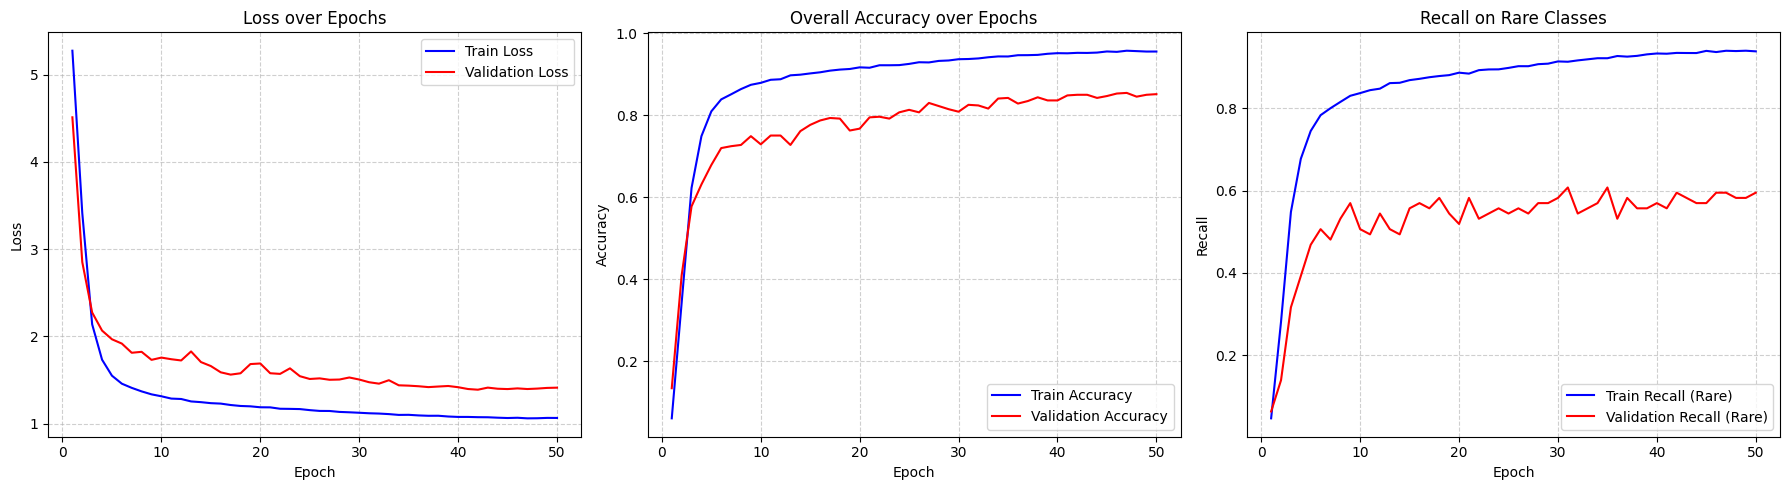

In [ ]:
from torch import nn, optim
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm 
import os
from rare_traffic_signs import plot_metrics, ContrastiveLoss

lr = 5e-5
epochs = 50

params_to_update = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(params_to_update, lr=lr)
cross_entropy_loss = nn.CrossEntropyLoss(label_smoothing=0.10)
contrastive_loss = ContrastiveLoss()
loss_alpha = 0.5
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3, 
    steps_per_epoch=len(train_full_loader),
    epochs=epochs,
    pct_start=0.2,
)

best_val_loss = np.inf
best_val_accuracy = 0.0
best_val_recall_rare = 0.0
epochs_no_improve = 0
patience = int(epochs/2)

model_path = 'rare_traffic_signs_complex_model_efficientnet_feature_loss.pth'

train_accuracies = []
train_losses = []
train_recalls_rare = []
val_accuracies = []
val_losses = []
val_recalls_rare = []

classes = pd.read_json('./tests/classes.json', orient='index', convert_dates=False)
name_to_id = classes['id'].to_dict()
rare_class_names = set(classes.index[classes['type'] == 'rare'])
rare_class_ids = torch.tensor([name_to_id[name] for name in rare_class_names], device=device, dtype=torch.long)

for epoch in tqdm(range(epochs), position=0, desc='Epoch'):
    
    train_loss = train_correct = train_correct_rare = train_seen = train_seen_rare = 0
    val_loss = val_correct = val_correct_rare = val_seen = val_seen_rare = 0

    model.train()

    with tqdm(train_full_loader, position=1, leave=False, desc='Train') as pbar:
        for i, data in enumerate(pbar):
            inputs, targets = data[0].to(device), data[1].to(device).long()

            optimizer.zero_grad()

            logits, features = model(inputs)
            features = nn.functional.normalize(features, p=2, dim=1)
            loss = cross_entropy_loss(logits, targets) + loss_alpha * contrastive_loss(features, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

            is_target_rare = torch.isin(targets, rare_class_ids)

            train_loss += loss.item() * inputs.size(0)
            train_correct += torch.sum(logits.argmax(dim=-1)==targets).item()
            train_correct_rare += torch.sum((logits.argmax(dim=-1)==targets) * is_target_rare).item()
            train_seen += inputs.size(0)
            train_seen_rare += torch.sum(is_target_rare)

            pbar.set_postfix(
                loss=f'{train_loss/train_seen:.4f}',
                accuracy=f'{train_correct/train_seen:.4f}',
                recall_rare=f'{train_correct_rare/(train_seen_rare+1e-9):.4f}',
                lr=f'{optimizer.param_groups[0]["lr"]:.6f}'
            )

    model.eval()
    with torch.no_grad():
        for data in val_full_loader:
            inputs, targets = data[0].to(device), data[1].to(device).long()
            logits, _ = model(inputs)

            is_target_rare = torch.isin(targets, rare_class_ids)

            val_loss += cross_entropy_loss(logits, targets).item() * inputs.size(0)
            val_correct += torch.sum(logits.argmax(dim=-1)==targets).item()
            val_correct_rare += torch.sum((logits.argmax(dim=-1)==targets) * is_target_rare).item()
            val_seen += inputs.size(0)
            val_seen_rare += torch.sum(is_target_rare)
    
    train_loss /= train_seen
    train_accuracy = train_correct / train_seen
    train_recall_rare = train_correct_rare / (train_seen_rare+1e-9)
    val_loss /= val_seen
    val_accuracy = val_correct / val_seen
    val_recall_rare = val_correct_rare / (val_seen_rare+1e-9)
    
    tqdm.write(f'Epoch {epoch+1} - train accuracy: {train_accuracy:.4f} - train loss: {train_loss:.4f} - train recall rare: {train_recall_rare:.4f} - val accuracy: {val_accuracy:.4f} - val loss: {val_loss:.4f} - val recall rare: {val_recall_rare:.4f}')
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_recalls_rare.append(train_recall_rare)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_recalls_rare.append(val_recall_rare)

    if val_recall_rare > best_val_recall_rare or ((val_recall_rare == best_val_recall_rare) and (val_accuracy > best_val_accuracy)):
        tqdm.write(f'Validation recall on rare classes improved ({best_val_recall_rare:.4f} --> {val_recall_rare:.4f}). Saving model...')
        torch.save(model.state_dict(), model_path)
        best_val_recall_rare = val_recall_rare
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        tqdm.write(f'Validation recall on rare classes did not improve. Counter: {epochs_no_improve}/{patience}')

    if epochs_no_improve >= patience:
        tqdm.write('Early stopping triggered.')
        break


if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print('Finished Training. Loaded best model.')
else:
    print('No improvement during training. Using final model.')

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, train_recall_rare=train_recalls_rare, val_recall_rare=val_recalls_rare)

In [ ]:
model_path = 'rare_traffic_signs_complex_model_efficientnet_feature_loss.pth'
model.load_state_dict(torch.load(model_path))
model.to(device=device)

model.eval()

classes = pd.read_json('./tests/classes.json', orient='index', convert_dates=False)
name_to_id = classes['id'].to_dict()
rare_class_names = set(classes.index[classes['type'] == 'rare'])
rare_class_ids = torch.tensor([name_to_id[name] for name in rare_class_names], device=device, dtype=torch.long)

test_loss = test_correct = test_correct_rare = test_seen = test_seen_rare = 0

with torch.no_grad():
    for data in test_full_loader:
        inputs, targets = data[0].to(device), data[1].to(device).long()
        outputs, _ = model(inputs)

        is_target_rare = torch.isin(targets, rare_class_ids)
        
        test_loss += criterion(outputs, targets).item() * inputs.size(0)
        test_correct += torch.sum(outputs.argmax(dim=-1)==targets).item()
        test_correct_rare += torch.sum((outputs.argmax(dim=-1)==targets) * is_target_rare).item()
        test_seen += inputs.size(0)
        test_seen_rare += torch.sum(is_target_rare)

test_loss /= test_seen
test_accuracy = test_correct / test_seen
test_recall_rare = test_correct_rare / (test_seen_rare+1e-9)

print(f'Test loss: {test_loss:.6f}, test accuracy: {test_accuracy:.6f}, test recall on rare data: {test_recall_rare:.6f}')

C:\Users\fazul\AppData\Local\Temp\ipykernel_17856\2071047379.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path_finetune))
C:\Us

Test loss: 1.435140, test accuracy: 0.845802, test recall on rare data: 0.558140


# KNN on features

In [ ]:
import torch.nn.functional as F


model_path = 'rare_traffic_signs_complex_model_efficientnet_feature_loss.pth'
model.load_state_dict(torch.load(model_path))
model.to(device=device)

model.eval()

all_train_features = []
all_test_features = []
all_train_labels = []
all_test_labels = []

with torch.no_grad():
    for data in DataLoader(train_full_dataset, batch_size=256, shuffle=False):
        inputs, targets = data[0].to(device), data[1]
        _, features = model(inputs)
        all_train_features.append(F.normalize(features, p=2, dim=1).cpu().numpy())
        all_train_labels.append(targets.numpy())

    for data in DataLoader(val_test_full_dataset, batch_size=256, shuffle=False):
        inputs, targets = data[0].to(device), data[1]
        _, features = model(inputs)
        all_test_features.append(F.normalize(features, p=2, dim=1).cpu().numpy())
        all_test_labels.append(targets.numpy())

X_train = np.concatenate(all_train_features, axis=0)
X_test = np.concatenate(all_test_features, axis=0)
y_train = np.concatenate(all_train_labels, axis=0)
y_test = np.concatenate(all_test_labels, axis=0)

C:\Users\fazul\AppData\Local\Temp\ipykernel_17856\405562976.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path_finetune))


In [43]:
from sklearn.neighbors import KNeighborsClassifier
import joblib

classes = pd.read_json('./tests/classes.json', orient='index', convert_dates=False)
name_to_id = classes['id'].to_dict()
rare_class_names = set(classes.index[classes['type'] == 'rare'])
rare_class_ids = np.array([name_to_id[name] for name in rare_class_names], dtype=int)

knn_classifier = KNeighborsClassifier(n_neighbors=12, n_jobs=-1)
knn_classifier.fit(X_train, y_train)

knn_model_path = 'rare_traffic_signs_knn_classifier_head.joblib'
joblib.dump(knn_classifier, knn_model_path)

is_target_rare = np.isin(y_test, rare_class_ids)
test_predictions = knn_classifier.predict(X_test)
test_accuracy = np.mean(test_predictions == y_test)
test_recall_rare = np.sum((test_predictions == y_test) * is_target_rare) / np.sum(is_target_rare+1e-9)
print(f'Test accuracy: {test_accuracy:.6f}, test recall on rare data: {test_recall_rare:.6f}')

C:\Users\fazul\AppData\Local\Temp\ipykernel_17856\222275839.py:4: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  classes = pd.read_json('./tests/classes.json', orient='index', convert_dates=False)
C:\Users\fazul\AppData\Local\Temp\ipykernel_17856\222275839.py:4: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  classes = pd.read_json('./tests/classes.json', orient='index', convert_dates=False)
C:\Users\fazul\AppData\Local\Temp\ipykernel_17856\222275839.py:4: FutureWarning: The behavior 

Test accuracy: 0.831169, test recall on rare data: 0.551515
